# Inports

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd

from absl import app
from absl import flags
import os 
from os.path import join
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils import *
# from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions



# Central performance

In [ ]:
experiment_id = 'algorithm' + '_' + 'central' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
print(experiment_paths)
for exp_path in experiment_paths :
    
    history = pd.read_csv(join(exp_path, 'centralized.csv'))
    central_acc = history['val_accuracy']


    plt.plot(central_acc)

# Local performance

In [ ]:
experiment_id = 'cifar10' + '_' + 'local' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
experiment_path = experiment_paths[0]

for p in experiment_paths :
    print(p)
histories = [pd.read_csv(join(experiment_path, 'client_{}.csv'.format(i))) for i in range(len(os.listdir(experiment_path)))]

val_accs = [history['val_accuracy'] for history in histories]

# local_acc_avg = np.mean(val_accs, axis=0)
# plt.plot(local_acc_avg, label='local')
for acc in val_accs:
    plt.plot(acc)
plt.show() 


# Federated Learning performance

## FedAvg

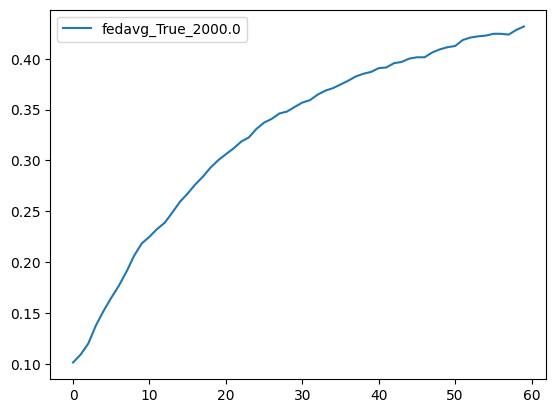

In [4]:

experiment_id = 'fedavg'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]



for p in experiment_paths :
    things = p.split('/')[-1].split('_')
    
    if not os.path.exists(join(p, 'accuracy.npy')): 
        continue 
    
    use_dp =  load_json_field(join(p, 'args.json'), 'use_dp')
    eps = load_json_field(join(p, 'args.json'), 'dp_epsilon')
    alg = load_json_field(join(p, 'args.json'), 'learning_algorithm')
    acc = np.load(join(p, 'accuracy.npy'))
    plt.plot(acc, label=alg + '_' + str(use_dp) + '_' + str(eps))

plt.legend()
plt.show()


## Fedsgd

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedsgd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedakd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

## Compare performance

In [ ]:
accuracies = [central_acc, local_acc_avg, fedavg_acc, fedsgd_acc]
labels = ['central', 'local', 'fedavg', 'fedsgd']

for acc, label in zip(accuracies, labels):
    plt.plot(acc, label=label)
plt.legend()
plt.show()

## DP relaxations noise vs epsilon

In [ ]:
n = 60_000 
bs = 200
e = 20 
delta = 1e-5
dp_types = ['dp', 'adv_cmp', 'rdp'] 
epsilons_range_1 = np.arange(0.01, 10, 0.1)
epsilons_range_2 = np.arange(10, 1000, 5)

noise_multipliers = np.zeros((len(dp_types), len(epsilons_range_1) ))
for dp_i, dp_type in enumerate(dp_types) : 
    for eps_i, eps in enumerate(epsilons_range_1) : 
        ac = DPAccountant(
            data_size= n,
            batch_size= bs, 
            epochs = e,
            target_delta = delta, 
            dp_type = dp_type
        )
        sigma = ac.get_noise_multiplier(target_epsilon=eps)
        noise_multipliers[dp_i, eps_i] = sigma



In [ ]:
for dp_i, dp_type in enumerate(dp_types) : 
    plt.plot(epsilons, noise_multipliers[dp_i, :], label=dp_type)
plt.legend()

## MIA results

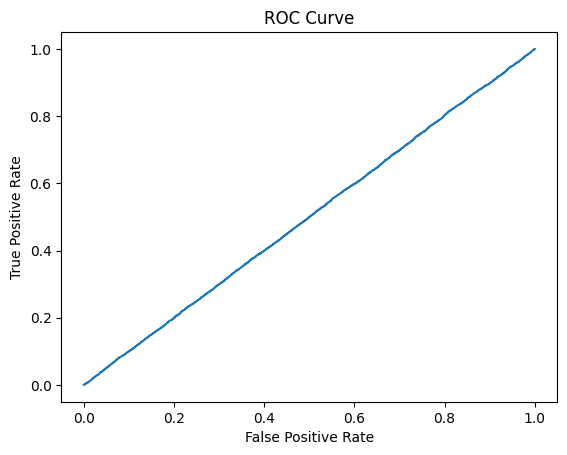

fpr: [0.     0.     0.     ... 0.9999 0.9999 1.    ]
tpr: [0.0000e+00 5.0000e-05 1.5000e-04 ... 9.9995e-01 1.0000e+00 1.0000e+00]
thresholds: [1.6669037  0.6669037  0.66685647 ... 0.60531336 0.605309   0.6052902 ]


In [14]:
id = 12
exp_id = 'exp_{}'.format(id)
EXP_PATH = join(DATA_PATH, exp_id)
attack_results_file = join(EXP_PATH, 'attack_results', 'attack_results.npy')
attack_results = np.load(attack_results_file, allow_pickle= True).item()  

fpr, tpr, thresholds = attack_results['fpr'], attack_results['tpr'], attack_results['thresholds']
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:", thresholds)